# baseline model performance - computed based on skytrax ratings

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
#make sure the commented_code_M2_thesis.py file is accessible from this notebook
sys.path.append("C:/Users/jadea/source/repos/functions to import M2 thesis")

In [2]:
#import baseline model 

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch

# Load the ABSA model and tokenizer
model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device('cuda')
model.to(device)

# Create a pipeline with the model and tokenizer, and ensure it uses the GPU
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

C:\ProgramData\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\transformers\convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [25]:
#import test set (control data)

full_test_set_2 = pd.read_csv('C:/Users/jadea/Notebooks/Mémoire M2 notebooks/skytrax_control.csv')
full_test_set_2.columns = ['Airline Name', 'Overall_Rating', 'Review_Title', 'Review Date',
       'Verified', 'Review', 'Aircraft', 'Type Of Traveller', 'Seat Type',
       'Route', 'Date Flown', 'seat comfort', 'crew flight',
       'food and beverages', 'on ground services', 'entertainment',
       'Wifi & Connectivity', 'Value For Money', 'Recommended', 'origin',
       'destination', 'Index']

In [26]:
len(full_test_set_2)

9936

In [4]:
full_test_set_2.iloc[1]['Review']

'  London to Kuala Lumpur. The plane was packed and the flight went smoothly but the condition of the toilets was terrible. I was given a seat in the front where there were quite a number of crying babies and infants; in such a situation, the toilets clearly need more checking for a minimum standard of cleanliness which was not the case. In this case, the toilets were left wet and the waste bin overflowing. Perhaps MAS personnel should get their crew to fly on one of the other highly rated competitive airlines like SIA or JAL as part of their training. The crew are seen at regular intervals donning gloves to tidy up the toilets to make the long flight bearable.'

In [8]:
classifier(full_test_set_2.iloc[1]['Review'], text_pair='')

[{'label': 'Negative', 'score': 0.9073877930641174}]

In [18]:
#define sentiment analysis pipeline

def sentiment_analysis(df, list_aspects, classifier, score=None):
    df_copy = df.copy()
    score_df = pd.DataFrame()
    score_df['Index']=df_copy['Index']
    for aspect in list_aspects:
        df_copy[aspect+'_prediction'] = df_copy.apply(lambda row, aspect=aspect: classifier(row['Review'], text_pair=aspect)[0]['label'], axis=1)
        df_copy[aspect+'_prediction'] = df_copy[aspect+'_prediction'].apply(lambda x: 'Positive' if x=='Positive' else 'Negative')
        if score is not None:
            df_copy[aspect+'_sentiment'] = df_copy[aspect].apply(lambda x: np.nan if np.isnan(x) else 'Positive' if int(x) in [4, 5] else 'Negative')
            score_df[aspect] = df_copy.apply(lambda row: np.nan if np.isnan(row[aspect]) else 1 if row[aspect+'_sentiment'] == row[aspect+'_prediction'] else 0, axis=1)
    if score is not None:
        return df_copy, score_df
    return df_copy

In [9]:
#Lemma Keyword Detection (LKD) dictionary
aspect_keywords_main_compare = {'food and beverages': ['food', 'beverage', 'meal', 'snack'],
 'entertainment': ['entertainment',
  'movie',
  'screen',
  'wifi',
  'headphone',
  'TV',
  'music',
  'IFE',
  'video',
  'internet',
  'wi-fi',
  'connectivity'],
'on ground services': [
        'check-in', 'lounge', 'counter', 'luggage', 'ground staff', 'ground crew', 'check in', 'gate'
    ],
 'delay': ['delay', 'late', 'punctuality'],
 'crew flight': ['attendant', 'steward', 'FA', 'crew', 'hostess', 'staff'],
 'seat comfort': ['legroom', 'armrest', 'recline', 'width', 'seat']}

In [31]:
#Aspect Extraction (LKD) step before sentiment classification

from commented_code_M2_thesis import aspect_extraction_keywords, plot_confusion_matrix_keywords, remove_stop_words2
pred_sentences_link_reviews_control, AE_pred_label_control = aspect_extraction_keywords(aspect_keywords_main_compare, full_test_set_2, skytrax_labels=True, allowed_keys=aspects_to_pred)


C:\Users/jadea/source/repos/functions to import M2 thesis\functions_to_import_M2_thesis.py:816: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


started
ended


In [32]:
#save
import pickle
with open("C:/Users/jadea/Notebooks/Mémoire M2 notebooks/pred_sentences_link_reviews_control.pkl", 'wb') as f:
    pickle.dump(pred_sentences_link_reviews_control, f)
with open("C:/Users/jadea/Notebooks/Mémoire M2 notebooks/AE_pred_label_control.pkl", 'wb') as f:
    pickle.dump(AE_pred_label_control, f)

In [2]:
#load
import pickle
with open("C:/Users/jadea/Notebooks/Mémoire M2 notebooks/pred_sentences_link_reviews_control.pkl", 'rb') as f:
    pred_sentences_link_reviews_control = pickle.load(f)
with open("C:/Users/jadea/Notebooks/Mémoire M2 notebooks/AE_pred_label_control.pkl", 'rb') as f:
    AE_pred_label_control = pickle.load(f)
    

In [3]:
#show
pred_sentences_link_reviews_control

{'food and beverages': {'The portion size for meals are smaller than the size of an iPhone 14 Pro Max (not an exaggeration) and meal choices were limited after the first 9 rows as they had run out.': 87026,
  'The cabin was not adequately cleaned as there was food on my armrest and rubbish / chewing gum in the seat pocket in front of me.': 87026,
  'When the cabin crew ordered meals for me, I told them that I don’t need the meal and I need to rest.': 62433,
  'The staff were brilliant, food delicious and very presentable.': 37923,
  'Not only was there no bed or even an upgraded recliner seat, there were no blankets, no pillows, no service and a little snack in a cardboard box.': 66488,
  "we got into the cabin my son seated in a different row, while a sat with my mother, the seats were comfortable, the IFE was good, and the food wasn't the best but appetizing, and the staff was very helpful.": 39771,
  'The food was OK, a meal on departure, a snack in between and then a rubbery egg br

In [4]:
AE_pred_label_control

{'food and beverages': {'The portion size for meals are smaller than the size of an iPhone 14 Pro Max (not an exaggeration) and meal choices were limited after the first 9 rows as they had run out.': 0,
  'The cabin was not adequately cleaned as there was food on my armrest and rubbish / chewing gum in the seat pocket in front of me.': 0,
  'When the cabin crew ordered meals for me, I told them that I don’t need the meal and I need to rest.': 1,
  'The staff were brilliant, food delicious and very presentable.': 1,
  'Not only was there no bed or even an upgraded recliner seat, there were no blankets, no pillows, no service and a little snack in a cardboard box.': 0,
  "we got into the cabin my son seated in a different row, while a sat with my mother, the seats were comfortable, the IFE was good, and the food wasn't the best but appetizing, and the staff was very helpful.": 0,
  'The food was OK, a meal on departure, a snack in between and then a rubbery egg breakfast before landing i

#### Evaluate Lemma Keywords Detection 

In [2]:
real_labels = pd.read_csv("C:/Users/jadea/Notebooks/Mémoire M2 notebooks/merged_real_labels_80_2.csv", sep=',')
real_labels.drop(columns='index',inplace=True)

In [7]:
test_set_LKD = pd.read_csv('C:/Users/jadea/Notebooks/Mémoire M2 notebooks/full_test_set_2.csv')

In [ ]:
full_test_set_lemma = remove_stop_words2(test_set_LKD, 'Review')

food and beverages true: {'IN': 107, 'NOT IN': 197}
food and beverages pred: {'IN': 101, 'NOT IN': 203}
entertainment true: {'IN': 66, 'NOT IN': 238}
entertainment pred: {'IN': 78, 'NOT IN': 226}
on ground services true: {'IN': 104, 'NOT IN': 200}
on ground services pred: {'IN': 99, 'NOT IN': 205}
delay true: {'IN': 92, 'NOT IN': 212}
delay pred: {'IN': 73, 'NOT IN': 231}
crew flight true: {'IN': 140, 'NOT IN': 164}
crew flight pred: {'IN': 191, 'NOT IN': 113}
seat comfort true: {'IN': 87, 'NOT IN': 217}
seat comfort pred: {'IN': 111, 'NOT IN': 193}


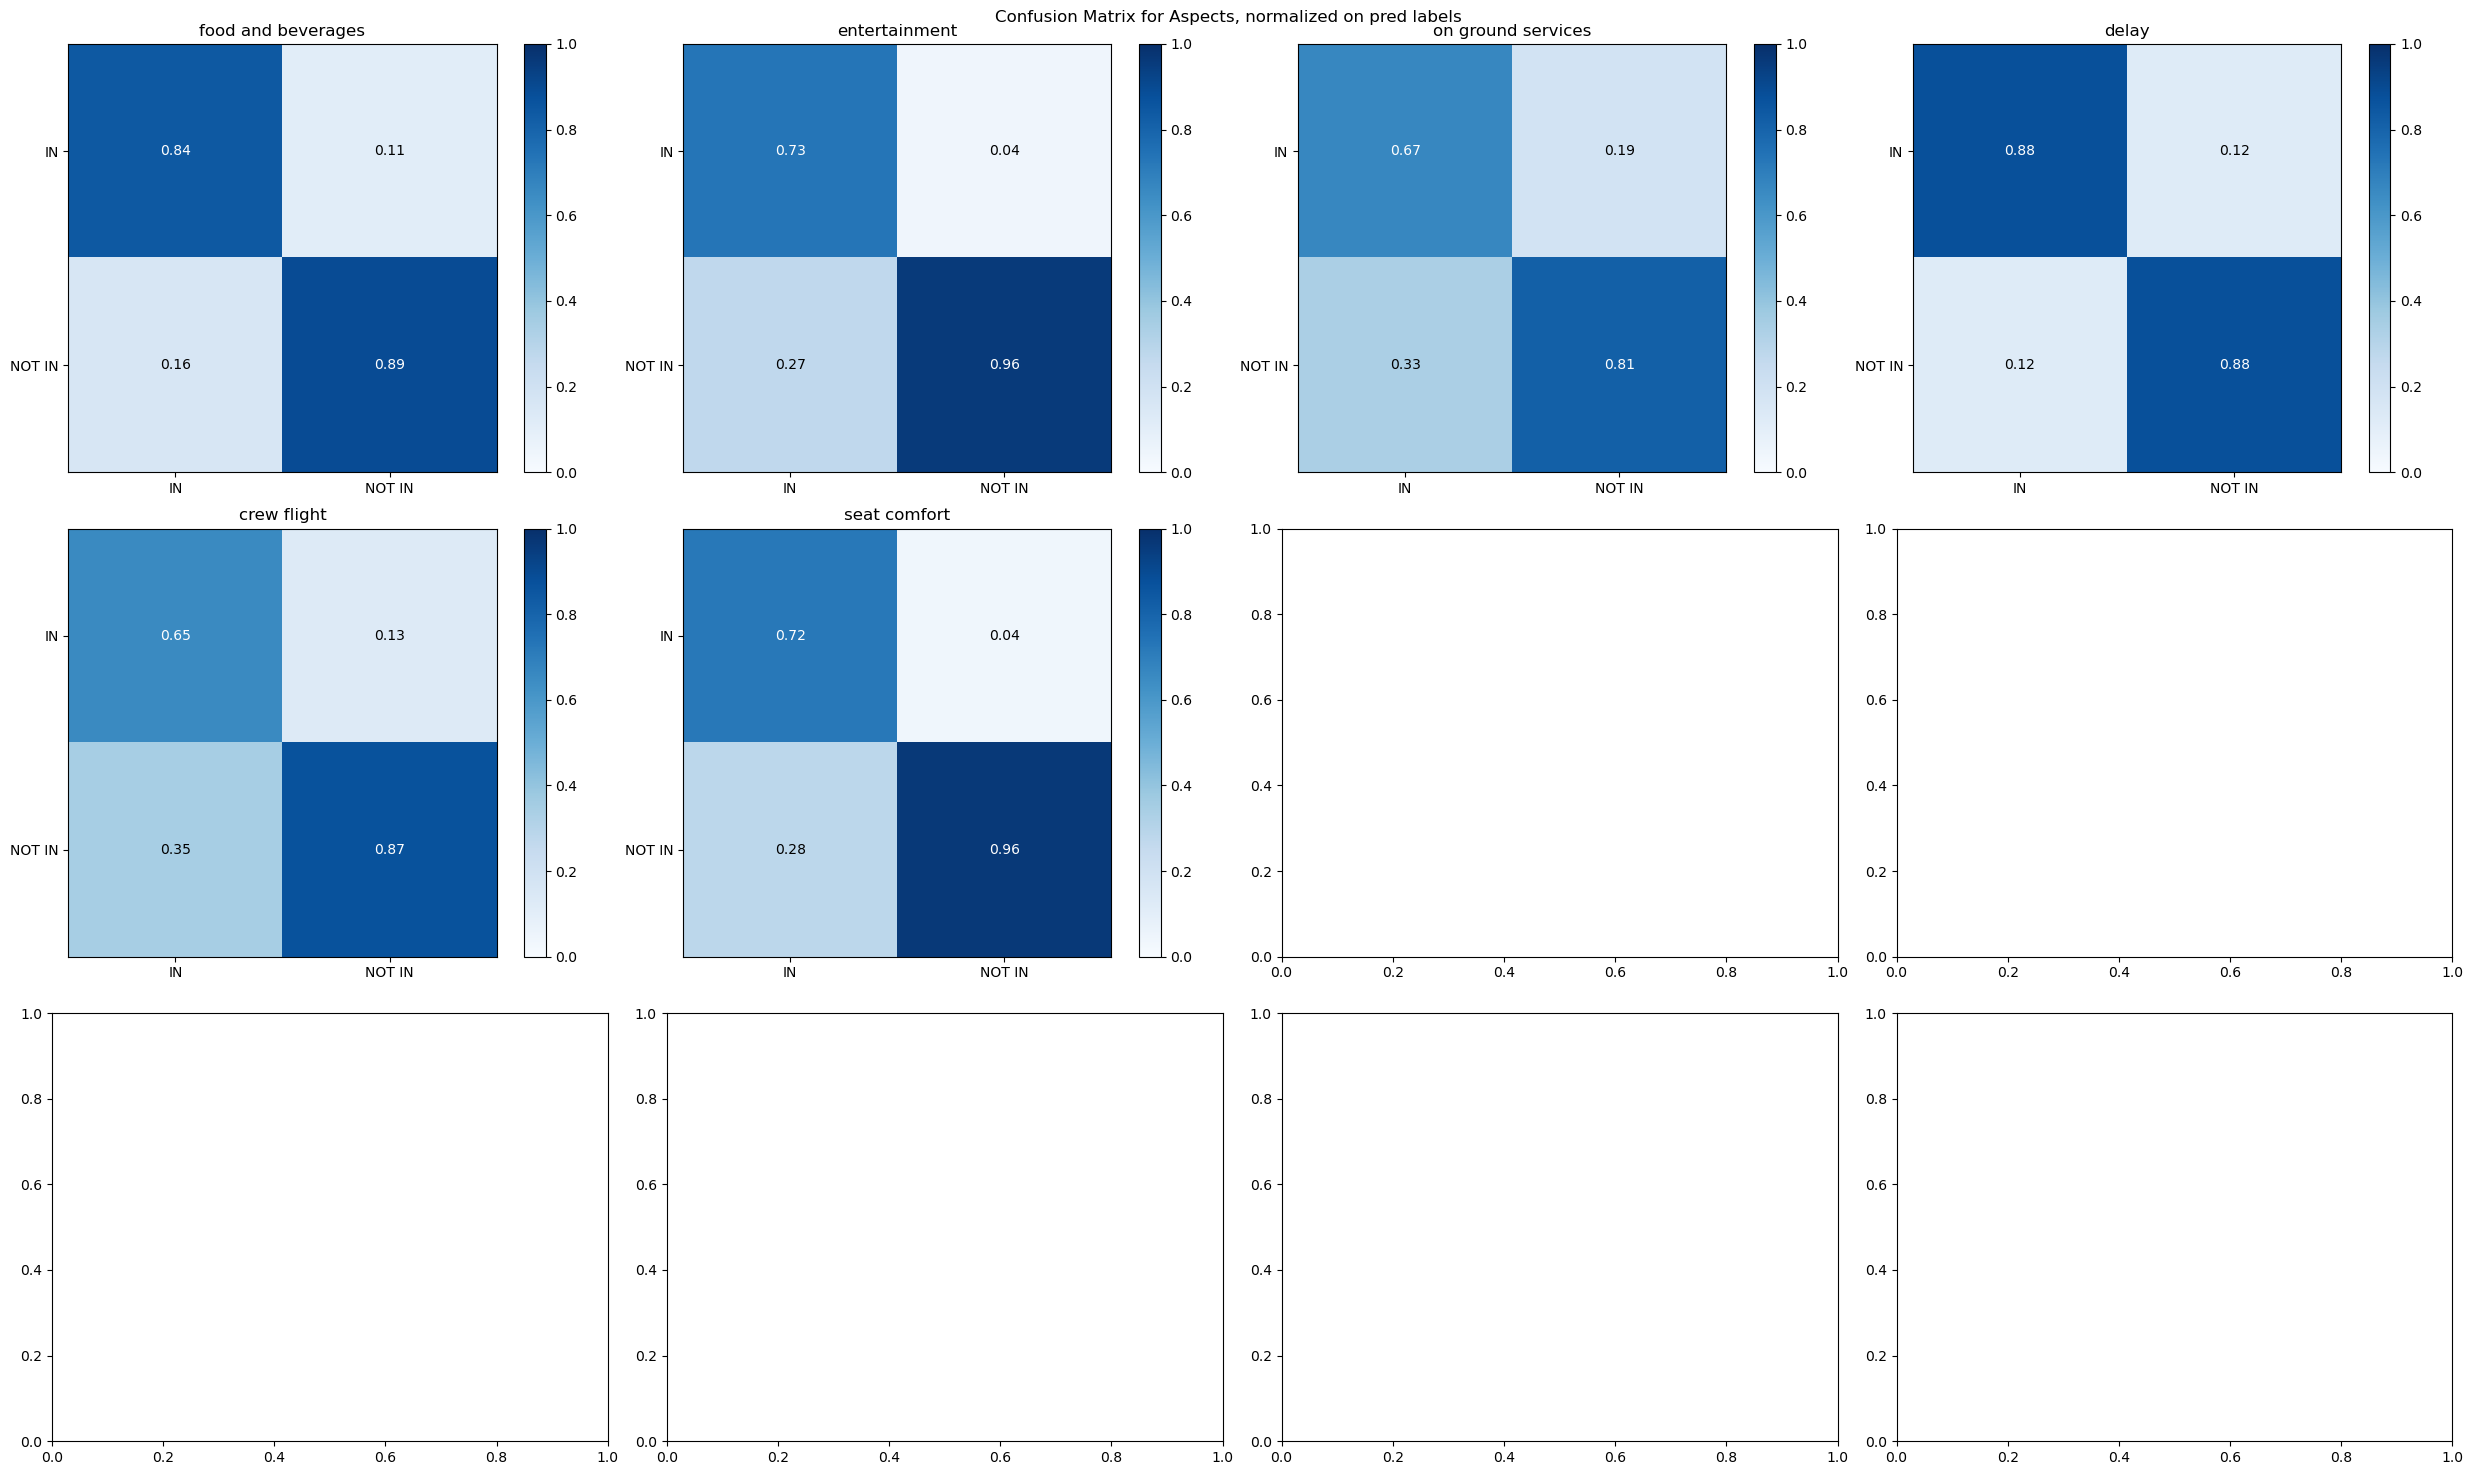

In [10]:
scores_df = plot_confusion_matrix_keywords(aspect_keywords_main_compare, full_test_set_lemma, real_labels, normalize='pred')

In [11]:
scores_df

,Aspect,Accuracy Score,F1 Score,Recall,Precision,F1 score skl
0,food and beverages,0.875000,0.817308,0.794393,0.841584,0.817308
1,entertainment,0.901316,0.791667,0.863636,0.730769,0.791667
2,on ground services,0.766447,0.650246,0.634615,0.666667,0.650246
3,delay,0.878289,0.775758,0.695652,0.876712,0.775758
4,crew flight,0.733553,0.755287,0.892857,0.654450,0.755287
5,seat comfort,0.875000,0.808081,0.919540,0.720721,0.808081


#### model performance on bipolar (extreme) reviews

1927
386
182
ok full_test_set_bipolar seat comfort


C:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


pred 59      Negative
169     Negative
173     Negative
484     Negative
499     Positive
          ...   
9645    Negative
9669    Positive
9742    Negative
9792    Positive
9874    Negative
Name: seat comfort_prediction, Length: 182, dtype: object

true 59      Negative
169     Negative
173     Positive
484     Negative
499     Positive
          ...   
9645    Negative
9669    Positive
9742    Negative
9792    Positive
9874    Negative
Name: seat comfort_sentiment, Length: 182, dtype: object
number of bipolar reviews talking about seat comfort 182
Accuracy: 0.687
Precision (Negative): 0.677
Recall (Negative): 0.843
F1 Score (Negative): 0.751
Precision (Positive): 0.709
Recall (Positive): 0.487
F1 Score (Positive): 0.578
F1 Score (Macro): 0.664
ok conf seat comfort
3061
433
309
ok full_test_set_bipolar crew flight


C:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


pred 115     Positive
131     Positive
169     Negative
193     Negative
227     Negative
          ...   
9860    Positive
9880    Negative
9894    Negative
9911    Negative
9919    Negative
Name: crew flight_prediction, Length: 309, dtype: object

true 115     Positive
131     Positive
169     Positive
193     Negative
227     Negative
          ...   
9860    Positive
9880    Positive
9894    Positive
9911    Negative
9919    Negative
Name: crew flight_sentiment, Length: 309, dtype: object
number of bipolar reviews talking about crew flight 309
Accuracy: 0.518
Precision (Negative): 0.392
Recall (Negative): 0.949
F1 Score (Negative): 0.555
Precision (Positive): 0.931
Recall (Positive): 0.318
F1 Score (Positive): 0.473
F1 Score (Macro): 0.514
ok conf crew flight
2021
350
218
ok full_test_set_bipolar food and beverages


C:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


pred 4       Negative
119     Positive
131     Positive
159     Positive
194     Positive
          ...   
9793    Negative
9834    Positive
9836    Positive
9853    Negative
9860    Negative
Name: food and beverages_prediction, Length: 218, dtype: object

true 4       Negative
119     Negative
131     Negative
159     Negative
194     Negative
          ...   
9793    Negative
9834    Negative
9836    Positive
9853    Negative
9860    Negative
Name: food and beverages_sentiment, Length: 218, dtype: object
number of bipolar reviews talking about food and beverages 218
Accuracy: 0.670
Precision (Negative): 0.867
Recall (Negative): 0.714
F1 Score (Negative): 0.783
Precision (Positive): 0.235
Recall (Positive): 0.444
F1 Score (Positive): 0.308
F1 Score (Macro): 0.545
ok conf food and beverages
1759
560
267
ok full_test_set_bipolar on ground services


C:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


pred 30      Negative
73      Negative
91      Negative
98      Negative
108     Negative
          ...   
9738    Positive
9798    Negative
9816    Negative
9838    Negative
9931    Negative
Name: on ground services_prediction, Length: 267, dtype: object

true 30      Negative
73      Negative
91      Negative
98      Positive
108     Negative
          ...   
9738    Negative
9798    Positive
9816    Negative
9838    Negative
9931    Positive
Name: on ground services_sentiment, Length: 267, dtype: object
number of bipolar reviews talking about on ground services 267
Accuracy: 0.757
Precision (Negative): 0.862
Recall (Negative): 0.842
F1 Score (Negative): 0.852
Precision (Positive): 0.300
Recall (Positive): 0.333
F1 Score (Positive): 0.316
F1 Score (Macro): 0.584
ok conf on ground services
1531
289
136
ok full_test_set_bipolar entertainment


C:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


pred 106     Negative
137     Negative
176     Positive
276     Positive
311     Negative
          ...   
9834    Positive
9886    Negative
9912    Negative
9927    Positive
9931    Negative
Name: entertainment_prediction, Length: 136, dtype: object

true 106     Positive
137     Negative
176     Negative
276     Negative
311     Negative
          ...   
9834    Positive
9886    Negative
9912    Negative
9927    Negative
9931    Negative
Name: entertainment_sentiment, Length: 136, dtype: object
number of bipolar reviews talking about entertainment 136
Accuracy: 0.529
Precision (Negative): 0.671
Recall (Negative): 0.613
F1 Score (Negative): 0.640
Precision (Positive): 0.294
Recall (Positive): 0.349
F1 Score (Positive): 0.319
F1 Score (Macro): 0.480
ok conf entertainment


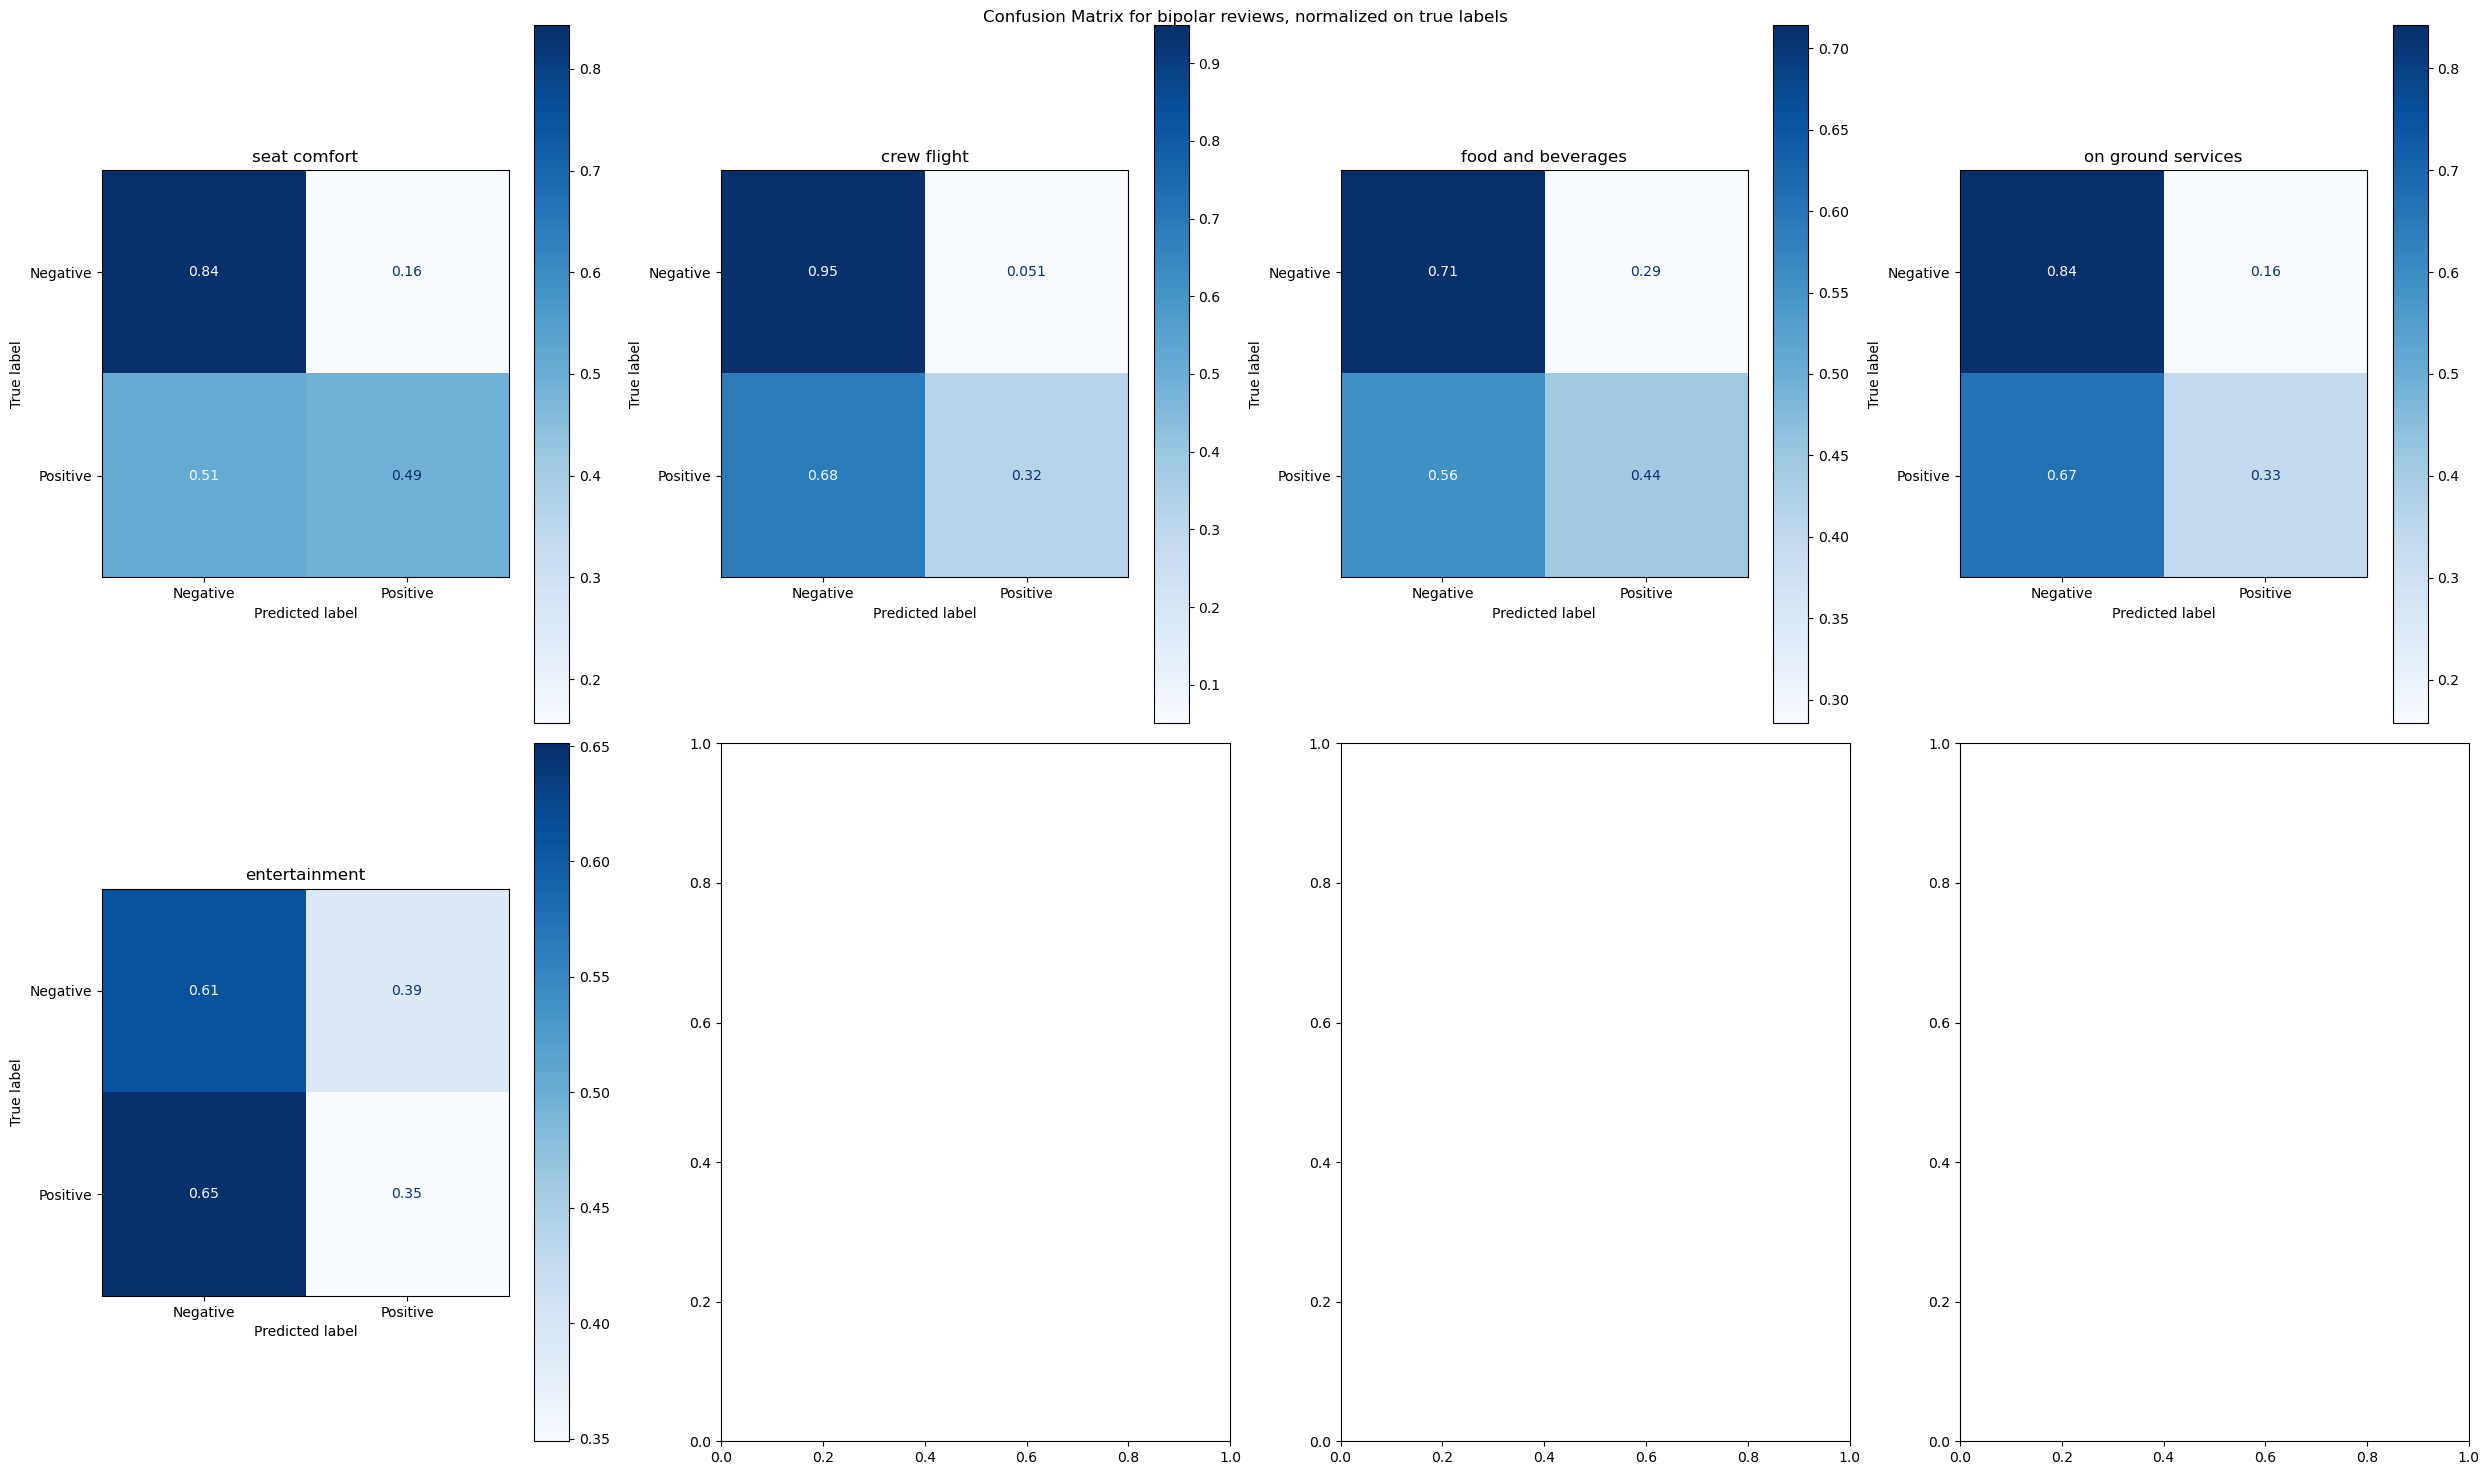

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
from commented_code_M2_thesis import get_AE_prediction_dict
from sklearn.metrics import precision_recall_fscore_support

import math
def distance_aspect_to_mean(row, aspect, aspects):
    if row[aspect] is not None:
        diff = row[aspect]-row[aspects].mean()
        return abs(diff)
    else:
        return np.nan
        
# Assuming list_aspects contains the names of the aspects
fig, axes = plt.subplots(2, 4, figsize=(25, 15))  # Adjust the figsize as needed
plt.suptitle('Confusion Matrix for bipolar reviews, normalized on true labels') 

aspects_to_pred = ['seat comfort', 'crew flight',
       'food and beverages', 'on ground services', 'entertainment']
all_aspects = ['seat comfort', 'crew flight',
       'food and beverages', 'on ground services', 'entertainment',
       'Wifi & Connectivity', 'Value For Money']
aspect_thresholds = [1.2, 1.43, 1.29, 1.33, 1.6]
bipolar = True
    

for ax, aspect, aspect_threshold in zip(axes.flatten(), aspects_to_pred, aspect_thresholds):
    
    test_data_copy= full_test_set_2.copy()
    ax.set_title(aspect)

    test_data_copy.dropna(subset=aspect, inplace=True)

    AE_recognized_index = np.unique(list(pred_sentences_link_reviews_control[aspect].values()))
    print(len(set(AE_recognized_index)))
    
    if bipolar == True:
        test_data_copy['dist_{}'.format(aspect)] = test_data_copy.apply(lambda x: distance_aspect_to_mean(x, aspect, all_aspects), axis=1)
        index_bipolar = test_data_copy[test_data_copy['dist_{}'.format(aspect)] > aspect_threshold]['Index']
        print(len(set(index_bipolar)))
        index_evaluate = set(AE_recognized_index)&set(index_bipolar)
    else:
        index_evaluate = AE_recognized_index
    print(len(index_evaluate))
    full_test_set_to_evaluate = test_data_copy[test_data_copy['Index'].isin(index_evaluate)]
    print('ok full_test_set_bipolar', aspect)
    
    #compute prediction
    pred_results, score_df = sentiment_analysis(full_test_set_to_evaluate, [aspect], classifier, score='yes')
    pred = pred_results[aspect+'_prediction']
    true = pred_results[aspect+'_sentiment']
    print('pred', pred)
    print('')
    print('true', true)
    print('number of bipolar reviews talking about', aspect, len(true))

    #metrics
    accuracy = (pred == true).mean()
    precision, recall, f1, support = precision_recall_fscore_support(true, pred, average=None, labels=['Negative', 'Positive'])
    _, _, f1_macro, _ = precision_recall_fscore_support(true, pred, average='macro', labels=['Negative','Positive'])
    # Display the results
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision (Negative): {precision[0]:.3f}')
    print(f'Recall (Negative): {recall[0]:.3f}')
    print(f'F1 Score (Negative): {f1[0]:.3f}')
    print(f'Precision (Positive): {precision[1]:.3f}')
    print(f'Recall (Positive): {recall[1]:.3f}')
    print(f'F1 Score (Positive): {f1[1]:.3f}')
    print(f'F1 Score (Macro): {f1_macro:.3f}')
    
    ConfusionMatrixDisplay.from_predictions(true, pred, normalize='true', cmap='Blues', ax=ax)
    # Adjust the normalization, cmap, and other parameters as needed
    print('ok conf', aspect)
plt.tight_layout()  # Adjust subplot parameters to give room for titles and labels
plt.show()

#### model performance on a subset of random reviews 

1927
1927
ok full_test_set_evaluate seat comfort


C:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


pred 2294    Negative
2429    Positive
1       Negative
7977    Positive
2702    Positive
          ...   
2433    Positive
8246    Negative
4887    Negative
8018    Negative
8426    Positive
Name: seat comfort_prediction, Length: 500, dtype: object

true 2294    Negative
2429    Positive
1       Negative
7977    Positive
2702    Positive
          ...   
2433    Positive
8246    Negative
4887    Negative
8018    Negative
8426    Negative
Name: seat comfort_sentiment, Length: 500, dtype: object
number of bipolar reviews talking about seat comfort 500
Accuracy: 0.866
Precision (Negative): 0.897
Recall (Negative): 0.876
F1 Score (Negative): 0.887
Precision (Positive): 0.822
Recall (Positive): 0.851
F1 Score (Positive): 0.836
F1 Score (Macro): 0.861
ok conf seat comfort
3061
3061
ok full_test_set_evaluate crew flight


C:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


pred 8839    Negative
9002    Negative
969     Positive
9023    Negative
3280    Negative
          ...   
7099    Negative
6671    Negative
3156    Positive
5963    Positive
350     Negative
Name: crew flight_prediction, Length: 500, dtype: object

true 8839    Negative
9002    Negative
969     Positive
9023    Positive
3280    Negative
          ...   
7099    Negative
6671    Positive
3156    Negative
5963    Positive
350     Negative
Name: crew flight_sentiment, Length: 500, dtype: object
number of bipolar reviews talking about crew flight 500
Accuracy: 0.814
Precision (Negative): 0.761
Recall (Negative): 0.911
F1 Score (Negative): 0.829
Precision (Positive): 0.892
Recall (Positive): 0.718
F1 Score (Positive): 0.796
F1 Score (Macro): 0.812
ok conf crew flight
2021
2021
ok full_test_set_evaluate food and beverages


C:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


pred 4084    Negative
1882    Negative
7973    Negative
2190    Negative
4645    Negative
          ...   
8851    Negative
9477    Negative
6516    Negative
4044    Negative
4254    Positive
Name: food and beverages_prediction, Length: 500, dtype: object

true 4084    Negative
1882    Negative
7973    Negative
2190    Negative
4645    Negative
          ...   
8851    Negative
9477    Negative
6516    Negative
4044    Negative
4254    Negative
Name: food and beverages_sentiment, Length: 500, dtype: object
number of bipolar reviews talking about food and beverages 500
Accuracy: 0.860
Precision (Negative): 0.929
Recall (Negative): 0.829
F1 Score (Negative): 0.876
Precision (Positive): 0.781
Recall (Positive): 0.905
F1 Score (Positive): 0.839
F1 Score (Macro): 0.858
ok conf food and beverages
1759
1759
ok full_test_set_evaluate on ground services


C:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


pred 3629    Positive
6374    Negative
8518    Negative
6021    Negative
5460    Negative
          ...   
7490    Positive
3097    Negative
9766    Negative
6729    Negative
3825    Negative
Name: on ground services_prediction, Length: 500, dtype: object

true 3629    Positive
6374    Negative
8518    Negative
6021    Negative
5460    Negative
          ...   
7490    Positive
3097    Negative
9766    Negative
6729    Negative
3825    Negative
Name: on ground services_sentiment, Length: 500, dtype: object
number of bipolar reviews talking about on ground services 500
Accuracy: 0.886
Precision (Negative): 0.939
Recall (Negative): 0.900
F1 Score (Negative): 0.919
Precision (Positive): 0.768
Recall (Positive): 0.850
F1 Score (Positive): 0.807
F1 Score (Macro): 0.863
ok conf on ground services
1531
1531
ok full_test_set_evaluate entertainment


C:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


pred 8719    Positive
9363    Positive
6014    Negative
5517    Positive
5895    Negative
          ...   
7318    Negative
891     Negative
619     Positive
2899    Negative
5808    Negative
Name: entertainment_prediction, Length: 500, dtype: object

true 8719    Positive
9363    Positive
6014    Negative
5517    Positive
5895    Negative
          ...   
7318    Positive
891     Negative
619     Positive
2899    Negative
5808    Negative
Name: entertainment_sentiment, Length: 500, dtype: object
number of bipolar reviews talking about entertainment 500
Accuracy: 0.792
Precision (Negative): 0.853
Recall (Negative): 0.785
F1 Score (Negative): 0.818
Precision (Positive): 0.718
Recall (Positive): 0.803
F1 Score (Positive): 0.758
F1 Score (Macro): 0.788
ok conf entertainment


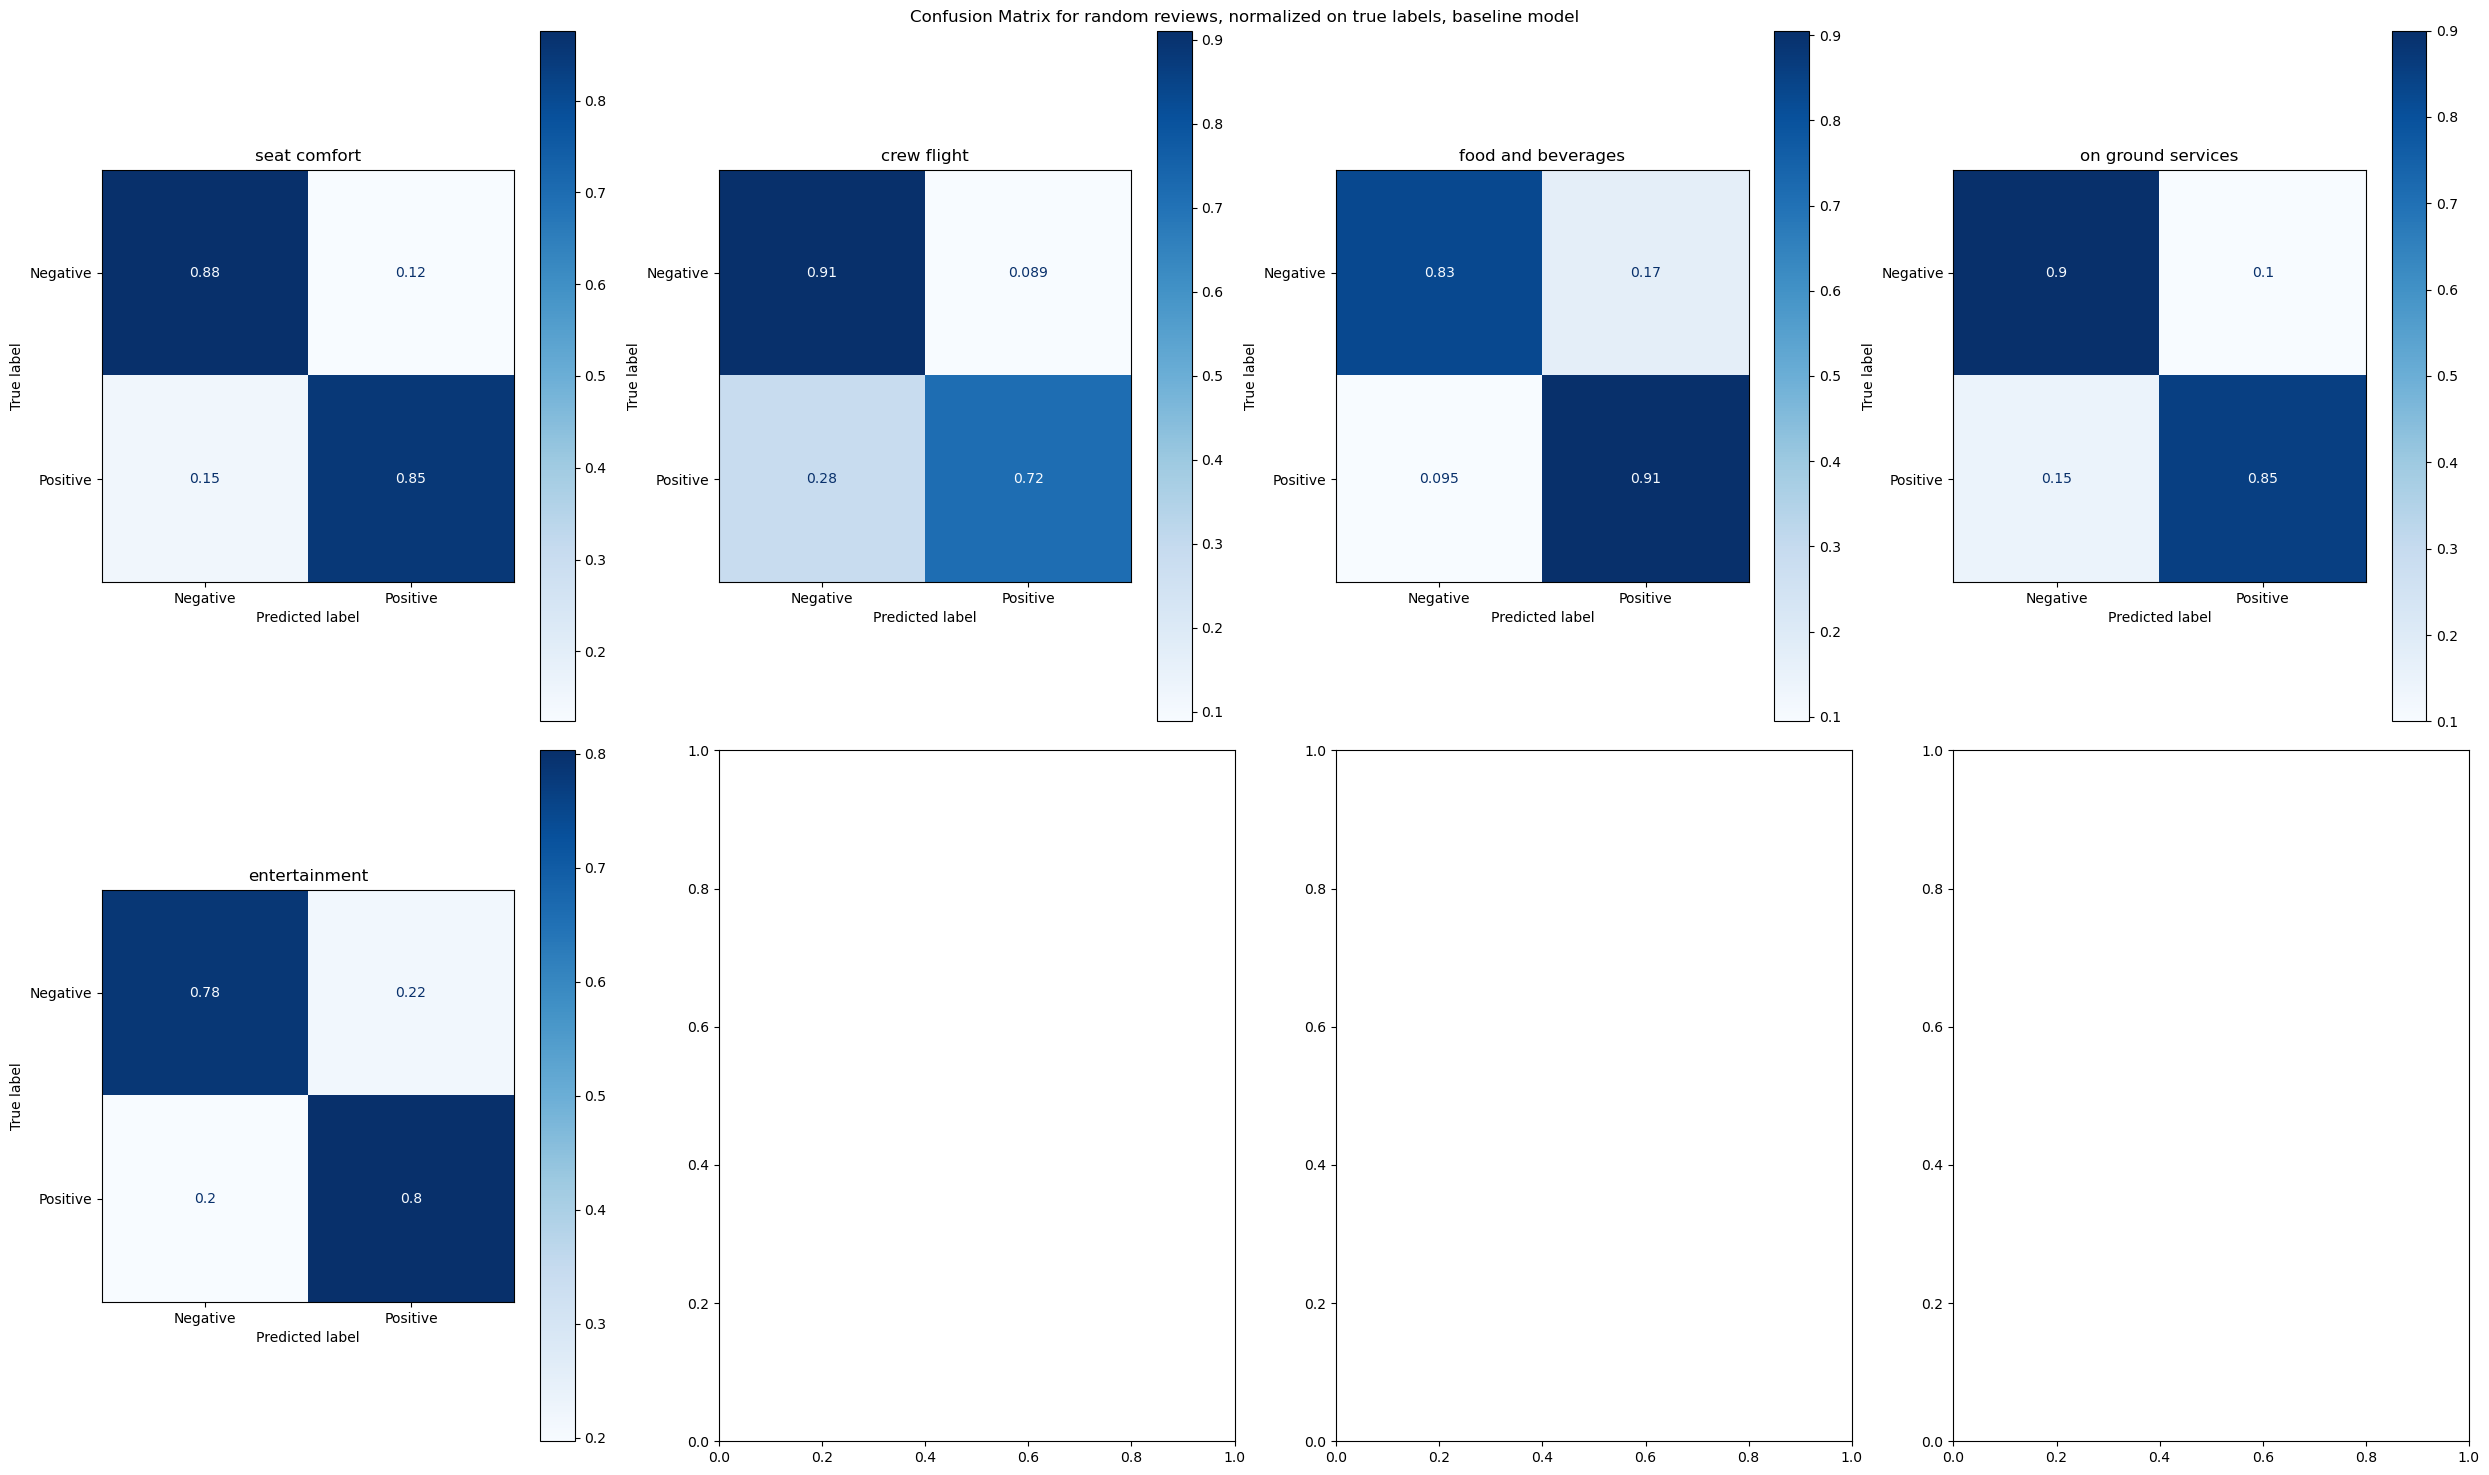

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
from commented_code_M2_thesis import get_AE_prediction_dict
from sklearn.metrics import precision_recall_fscore_support

import math
def distance_aspect_to_mean(row, aspect, aspects):
    if row[aspect] is not None:
        diff = row[aspect]-row[aspects].mean()
        return abs(diff)
    else:
        return np.nan
        
#index_bipolar = test_pred[test_pred[aspects].std(axis=1)<3][aspects].index
# Assuming list_aspects contains the names of the aspects
fig, axes = plt.subplots(2, 4, figsize=(25, 15))  # Adjust the figsize as needed
plt.suptitle('Confusion Matrix for random reviews, normalized on true labels, baseline model') 

aspects_to_pred = ['seat comfort', 'crew flight',
       'food and beverages', 'on ground services', 'entertainment']
all_aspects = ['seat comfort', 'crew flight',
       'food and beverages', 'on ground services', 'entertainment',
       'Wifi & Connectivity', 'Value For Money']
bipolar = False

#pred_sentences_link_reviews_control, AE_pred_label_control = get_AE_prediction_dict(full_test_set_2, aspects_to_pred, aspect_keywords_main_compare, skytrax_labels=True)#, real_labels=real_labels_all)
    

for ax, aspect, aspect_threshold in zip(axes.flatten(), aspects_to_pred, aspect_thresholds):
    
    test_data_copy= full_test_set_2.copy()
    ax.set_title(aspect)
    
    #dropna in skytrax ratings for aspect
    #keep only bipolar or all
    #do aspect extraction
    #keep only the extracted reviews

    #index_aspect_extraction = new_real_labels[~new_real_labels[aspect].isna()]['Index']
    test_data_copy.dropna(subset=aspect, inplace=True)

    AE_recognized_index = np.unique(list(pred_sentences_link_reviews_control[aspect].values()))
    print(len(set(AE_recognized_index)))
    
    if bipolar == True:
        test_data_copy['dist_{}'.format(aspect)] = test_data_copy.apply(lambda x: distance_aspect_to_mean(x, aspect, all_aspects), axis=1)
        index_bipolar = test_data_copy[test_data_copy['dist_{}'.format(aspect)] > aspect_threshold]['Index']
        #index_bipolar = test_data_copy[test_data_copy['dist_{}'.format(aspect)] <= aspect_threshold]['Index']
        #full_test_set_bipolar_ratings = test_data_copy[test_data_copy['Index'].isin(index_bipolar)]
        print(len(set(index_bipolar)))
        index_evaluate = set(AE_recognized_index)&set(index_bipolar)
    else:
        index_evaluate = AE_recognized_index
        
    print(len(index_evaluate))
    full_test_set_to_evaluate = test_data_copy[test_data_copy['Index'].isin(index_evaluate)].sample(500)
    print('ok full_test_set_evaluate', aspect)
    
    #compute prediction
    pred_results, score_df = sentiment_analysis(full_test_set_to_evaluate, [aspect], classifier, score='yes')
    pred = pred_results[aspect+'_prediction']
    true = pred_results[aspect+'_sentiment']
    print('pred', pred)
    print('')
    print('true', true)
    print('number of bipolar reviews talking about', aspect, len(true))

    #metrics
    accuracy = (pred == true).mean()
    precision, recall, f1, support = precision_recall_fscore_support(true, pred, average=None, labels=['Negative', 'Positive'])
    _, _, f1_macro, _ = precision_recall_fscore_support(true, pred, average='macro', labels=['Negative','Positive'])
    # Display the results
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision (Negative): {precision[0]:.3f}')
    print(f'Recall (Negative): {recall[0]:.3f}')
    print(f'F1 Score (Negative): {f1[0]:.3f}')
    print(f'Precision (Positive): {precision[1]:.3f}')
    print(f'Recall (Positive): {recall[1]:.3f}')
    print(f'F1 Score (Positive): {f1[1]:.3f}')
    print(f'F1 Score (Macro): {f1_macro:.3f}')
    
    ConfusionMatrixDisplay.from_predictions(true, pred, normalize='true', cmap='Blues', ax=ax)
    # Adjust the normalization, cmap, and other parameters as needed
    print('ok conf', aspect)
plt.tight_layout()  # Adjust subplot parameters to give room for titles and labels
plt.show()